# Building separate Ni2+/3+/4+ force fields

In [1]:
import matplotlib.pyplot as plt

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=False

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


for i in {1..19}; do (mkdir "outcar${i}"; mv "outcar${i}.txt" "outcar${i}/OUTCAR"); done
for i in {1..19}; do (echo "outcar/outcar${i}" >> data_list.txt); done
for f in $(ls OUTCARS/); do echo "OUTCARS/$f" >> data_list.txt; done

In [2]:
# !ase db DFT.db

import ase
from ase import db

db_selection = db.connect("DFT_selection.db")
db_ref = db.connect("DFT.db")

for row in db_ref.select():
    if row.energy<-320:
        db_selection.write(row.toatoms())
        
!ase db DFT_selection.db

id|age|user   |formula|calculator|  energy|natoms|  fmax|pbc| volume|charge|    mass| smax
 1| 2s|tjams20|Ni18O36|vasp      |-323.985|    54| 7.129|TTT|603.577| 0.000|1632.445|0.062
 2| 2s|tjams20|Ni18O36|vasp      |-320.967|    54| 8.127|TTT|603.577| 0.000|1632.445|0.044
 3| 2s|tjams20|Ni18O36|vasp      |-323.830|    54| 5.253|TTT|603.577| 0.000|1632.445|0.078
 4| 2s|tjams20|Ni18O36|vasp      |-321.649|    54| 8.199|TTT|603.577| 0.000|1632.445|0.056
 5| 2s|tjams20|Ni18O36|vasp      |-326.494|    54| 5.622|TTT|603.577| 0.000|1632.445|0.078
 6| 2s|tjams20|Ni18O36|vasp      |-325.994|    54| 6.301|TTT|603.577| 0.000|1632.445|0.072
 7| 2s|tjams20|Ni18O36|vasp      |-329.366|    54| 3.871|TTT|603.577| 0.000|1632.445|0.079
 8| 2s|tjams20|Ni18O36|vasp      |-328.416|    54| 3.880|TTT|603.577| 0.000|1632.445|0.080
 9| 2s|tjams20|Ni18O36|vasp      |-321.260|    54|14.413|TTT|560.481| 0.000|1632.445|0.081
10| 2s|tjams20|Ni18O36|vasp      |-325.080|    54|10.728|TTT|560.481| 0.000|1632.445|0.053

In [2]:
# Fetch the data from the database and generate structures.json
from ccs_fit.scripts.ccs_fetch import ccs_fetch

charge_dict={"Ni": 4.0, "O": -2.0}
ccs_fetch(mode="CCS+Q", DFT_DB="XXX.db", include_forces=True, charge_dict=charge_dict, R_c=6.0)


### Generate CCS_input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "True",
        "do_unconstrained_fit": "False" # It could be interesting to see what the fit would like to do if it is unconstrained, but that's an option you could test later
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"   
                }
        }
}

# CCS_input.json
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)
    
# Run ccs_fit
from ccs_fit import ccs_fit
ccs_fit("CCS_input.json")

# Define ccs calculator
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
with open("CCS_params_ZnO.json", "r") as f:
    CCS_params = json.load(f)
    
ccs= CCS(CCS_params,charge=True,q=charges,charge_scaling=True)

    Fetching data: 0it [00:00, ?it/s]


    Generating one-body information from training-set.
        Added elements:  []
    Generating two-body potentials from one-body information.


ValueError: zero-size array to reduction operation maximum which has no identity

In [3]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS+Q",DFT_DB="DFT.db",file_list="data_list.txt", overwrite=True, greedy=False) #false only takes last Outcars

    Building data-bases: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:03<00:00, 32.54it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [4]:
!ase db DFT.db

id|age|user   |formula|calculator|  energy|natoms|  fmax|pbc| volume|charge|    mass| smax
 1|32m|tjams20|Ni16O32|vasp      |-265.420|    48|16.357|TTT|563.563| 0.000|1451.062|0.008
 2|32m|tjams20|Ni16O32|vasp      |-268.483|    48|33.020|TTT|563.563| 0.000|1451.062|0.045
 3|32m|tjams20|Ni16O32|vasp      |-275.676|    48| 8.622|TTT|563.563| 0.000|1451.062|0.049
 4|32m|tjams20|Ni16O32|vasp      |-277.214|    48| 9.612|TTT|563.563| 0.000|1451.062|0.059
 5|32m|tjams20|Ni16O32|vasp      |-279.572|    48| 7.750|TTT|563.563| 0.000|1451.062|0.076
 6|32m|tjams20|Ni16O32|vasp      |-277.604|    48|23.071|TTT|563.563| 0.000|1451.062|0.059
 7|32m|tjams20|Ni16O32|vasp      |-283.575|    48| 5.495|TTT|563.563| 0.000|1451.062|0.076
 8|32m|tjams20|Ni16O32|vasp      |-281.972|    48|10.288|TTT|563.563| 0.000|1451.062|0.080
 9|32m|tjams20|Ni16O32|vasp      |-285.291|    48| 4.518|TTT|563.563| 0.000|1451.062|0.079
10|32m|tjams20|Ni16O32|vasp      |-284.171|    48| 5.234|TTT|563.563| 0.000|1451.062|0.082

In [3]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

charge_dict={"Ni": 4.0, "O": -2.0}
ccs_fetch(mode="CCS+Q",DFT_DB="DFT_selection.db", charge_dict=charge_dict, include_forces=Fit_on_forces)

    Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:04<00:00,  4.59it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [4]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "True",
        "do_unconstrained_fit": "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 5.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                # "Ni-Ni": {
                #         "Rcut": 5.0,
                #         "Resolution": 0.1,
                #         "Swtype": "rep",
                #         "const_type" : "Mono"
                # },
                # "O-O": {
                #         "Rcut": 5.0,
                #         "Resolution": 0.1,
                #         "Swtype": "rep",
                #         "const_type" : "Mono"
                # }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [5]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Ni', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: Ni-Ni
    Adding pair: Ni-O
    Adding pair: O-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-O
    Merging intervals for pair Ni-Ni; number of intervals reduced from 27 to 17. 
    Merging intervals for pair Ni-O; number of intervals reduced from 37 to 31. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    MSE of unconstrained problem is:  1.7330843799939144e-26
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
    Merging intervals for pair Ni-Ni; number of intervals reduced from 27 to 17. 


/Users/tjams20/Documents/repos/CCS/src/ccs_fit/fitting/objective.py:326: RuntimeWarning: invalid value encountered in sqrt
  self.charge_scaling = xx[-1] ** 0.5
/Users/tjams20/Documents/repos/CCS/src/ccs_fit/fitting/spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


    Merging intervals for pair Ni-O; number of intervals reduced from 37 to 31. 


    Finding optimum switch: 100%|███████████████████████████████████████████████████████████████████████████| 16337/16337 [01:48<00:00, 150.80it/s]


    The best switch is (4, 30, 4) with rmse: 0.02457844584183467, corresponding to distances of [2.83 4.46 2.47] Å for element pairs ['Ni-Ni', 'Ni-O', 'O-O'].
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [6]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT_selection.db")

  0%|                                                                                                                       | 0/22 [00:00<?, ?it/s]/usr/local/anaconda3/envs/Tantalizing/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.64it/s]


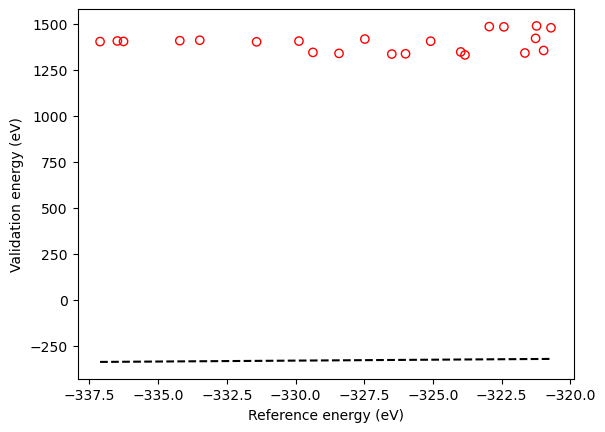

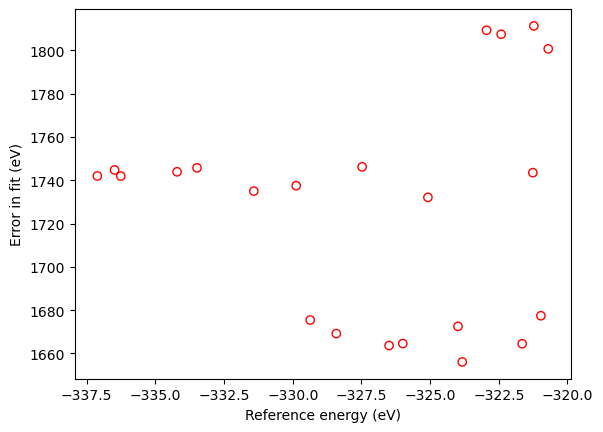

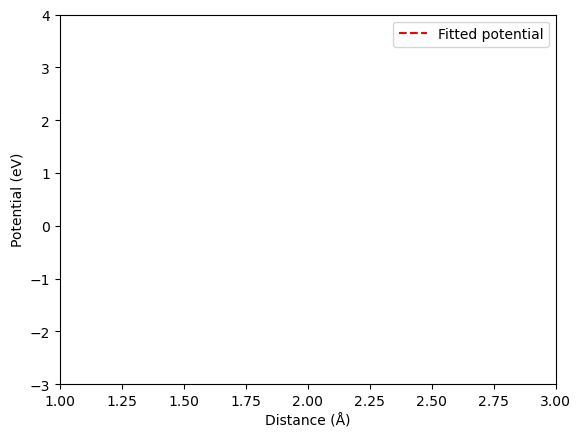

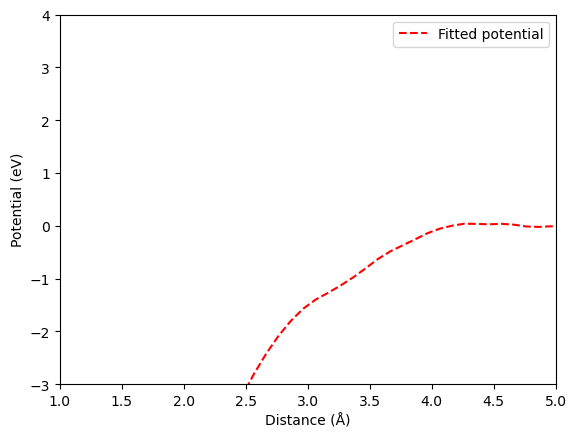

In [7]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass


with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

r = np.array(CCS_params["Two_body"][f'Ni-O']["r"])
e=CCS_params["Two_body"][f'Ni-O']["spl_a"]

plt.xlim(1, 3)
plt.ylim(-3, 4)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r, e ,'--', color='red', label="Fitted potential")
plt.legend()
plt.show()

with open("UNC_params.json", "r") as f:
    UNC_params = json.load(f)

r = np.array(UNC_params["Two_body"][f'Ni-O']["r"])
e=UNC_params["Two_body"][f'Ni-O']["spl_a"]

plt.xlim(1, 5)
plt.ylim(-3, 4)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r, e ,'--', color='red', label="Fitted potential")
plt.legend()
plt.show()

In [9]:
from ccs_fit.scripts.ccs_export_FF import write_FF
write_FF("CCS_params.json")

Writing LAMMPS and GULP splines.


/usr/local/anaconda3/envs/Tantalizing/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

### Cleaning up

In [21]:
from ase.io import read, write
from ase.constraints import StrainFilter
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import json
from ase.optimize import BFGS

opt_struct = read('DFT.db@40')

with open ('CCS_params.json','r') as f:
    CCS_params=json.load(f)

CCS_calc = CCS(CCS_params=CCS_params, charge=True,q=charge_dict,charge_scaling=True)
    
opt_struct.calc = CCS_calc

print(opt_struct.get_stress())

orig_cell = opt_struct.cell.copy()

sf = StrainFilter(opt_struct)
opt = BFGS(sf, trajectory='CCS_strain.traj')
opt.run(fmax=1e-4)
alat = opt_struct.cell[0][1] - opt_struct.cell[0][0]

CCS_strain_opt = read('CCS_strain.traj')
CCS_strain_opt_cell = CCS_strain_opt.cell

old_vol = np.prod(np.diag(orig_cell))
new_vol = np.prod(np.diag(CCS_strain_opt_cell))

write("NiO2_opt_ccs.POSCAR", CCS_strain_opt)

print("Volume change of {} %, as a result of the following lattice parameter changes:".format((new_vol-old_vol)/old_vol*100))
print([np.diag(CCS_strain_opt_cell-orig_cell)[i]/np.diag(orig_cell)[i]*100 for i in range(3)])

print(np.diag(CCS_strain_opt_cell))

[ 0.468336    0.53671444  0.52146363  0.01524351 -0.01714075  0.00777316]
      Step     Time          Energy         fmax
BFGS:    0 11:44:43     -278.018753      398.3344
BFGS:    1 11:44:43     -177.781879     1043.4549
BFGS:    2 11:44:44      131.719404     2488.5257
BFGS:    3 11:44:45      547.469130     4045.8514
BFGS:    4 11:44:45     1156.832421     5547.9458
BFGS:    5 11:44:46     1919.782165     6843.6616
BFGS:    6 11:44:47     3813.573932    10658.8095
BFGS:    7 11:44:48     4980.968668    12885.5056
BFGS:    8 11:44:50     7492.691347    18808.6133
BFGS:    9 11:44:51     7121.658629    17397.7962


KeyboardInterrupt: 

In [11]:
struct = read('CCS_strain.traj')

CCS_calc = CCS(CCS_params=CCS_params)

struct.calc = CCS_calc

opt = BFGS(struct, trajectory='opt.traj')
opt.run(fmax=0.001)

      Step     Time          Energy         fmax
BFGS:    0 11:14:32    10159.501814      620.0609
BFGS:    1 11:14:38     8880.913437      305.6270
BFGS:    2 11:14:44     8685.138860      497.8411
BFGS:    3 11:14:50     8469.187523      345.4139
BFGS:    4 11:14:56     8318.032389      304.3596
BFGS:    5 11:15:02     8163.802200      290.2422
BFGS:    6 11:15:08     8014.287989      225.4463
BFGS:    7 11:15:14     7881.282117      206.7641
BFGS:    8 11:15:20     7780.509367      137.5330
BFGS:    9 11:15:26     7722.589658      146.9033
BFGS:   10 11:15:32     7644.300487      141.8962
BFGS:   11 11:15:38     7623.604740      214.9205
BFGS:   12 11:15:44     7577.739909      155.1083
BFGS:   13 11:15:50     7505.309204      197.3189
BFGS:   14 11:15:55     7403.074980      161.3107
BFGS:   15 11:16:01     7300.417430      123.0253
BFGS:   16 11:16:07     7199.438530      141.1321
BFGS:   17 11:16:13     7123.979447      146.2079
BFGS:   18 11:16:19     7058.635364      144.3080
B

KeyboardInterrupt: 

In [ ]:
!ase gui CCS_strain.traj

In [6]:
# Read geometry optimized structure and run NVE Molecular dynamics 
import numpy as np
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)

dt = 0.5 * units.fs
steps = int(300)
MaxwellBoltzmannDistribution(struct, temperature_K=600)
dyn = VelocityVerlet(struct, timestep=dt)
interval = int(1)
dyn.attach(MDLogger(dyn, struct, 'output.log', mode="a"), interval=interval)
dyn.attach(Trajectory('output.traj', 'a', struct).write, interval=interval)
dyn.run(steps)

True

In [8]:
!ase gui output.traj

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.